TAGET: 查看获取的出租车GPS的偏移情况 \
1.从高德获取所在区域的经纬度范围\
2.将查询区域划分为若干个小区域\
3.获取每个小区域内的道路名称\
4.根据道路名称查询道路的折线信息\
5.可视化的绘制

#### Part 1 获取经纬度信息

In [6]:
import urllib.request 
from urllib import parse 
import json 
import re
import pandas as pd
import chart_studio.plotly as py
import plotly.graph_objs as go
import plotly
import numpy as np
from pandas import DataFrame

mykey=u'51cffc64fd38c249e18e2a8265ad06f9'

In [3]:
# 获取温州地区轮廓经纬度，划定矩阵
dist_Url = ('http://restapi.amap.com/v3/config/district?'
                'key={key}&keywords=温州&subdistrict=2&extensions=all')
dist_Url = parse.quote(dist_Url.format(key=mykey),safe="/:=&?#+!$,;'@()*[]")
response = urllib.request.urlopen(dist_Url)
data = response.read()

jsonData=json.loads(data)
polyline=re.split("[;\|]",jsonData['districts'][0]['polyline'])
print(polyline)

['121.074413,28.020475', '121.072726,28.020635', '121.071588,28.021384', '121.0711,28.0225', '121.071202,28.023596', '121.071832,28.026559', '121.071771,28.027411', '121.071609,28.028182', '121.07169,28.029582', '121.072239,28.030537', '121.07293,28.031065', '121.07417,28.031108', '121.075654,28.031007', '121.077198,28.030462', '121.078113,28.02888', '121.078722,28.026446', '121.078621,28.024274', '121.077604,28.022122', '121.076161,28.020924', '121.074413,28.020475', '121.043159,28.024978', '121.041968,28.025201', '121.040882,28.025614', '121.039944,28.02614', '121.039675,28.026633', '121.039631,28.027101', '121.039762,28.027525', '121.040239,28.028185', '121.040848,28.028472', '121.042073,28.028544', '121.042951,28.028434', '121.044236,28.027987', '121.044723,28.027659', '121.045009,28.027148', '121.045192,28.026187', '121.045122,28.025746', '121.044853,28.025424', '121.044314,28.025128', '121.043914,28.024989', '121.043159,28.024978', '121.054385,28.018931', '121.050729,28.019166', 

['121.074413,28.020475', '121.072726,28.020635', '121.071588,28.021384', '121.0711,28.0225', '121.071202,28.023596', '121.071832,28.026559', '121.071771,28.027411', '121.071609,28.028182', '121.07169,28.029582']

In [ ]:
max_lon=max_lat=0
min_lon=min_lat=float('inf')
for pair in polyline:
    lon,lat=pair.split(',')
    max_lon=max(max_lon,float(lon))
    max_lat=max(max_lat,float(lat))
    min_lon=min(min_lon,float(lon))
    min_lat=min(min_lat,float(lat))

#### Part 2 划分为小区域

In [120]:
#由于高德查询限制，需要将查询区域划分为小块
def generalID(column_num,row_num):
    latitude = (max_lat - min_lat)/column_num
    longitude = (max_lon - min_lon)/row_num
    polylists = []
 
    for i in range(column_num):
        left_latitude = min_lat + latitude * i
        righ_latitude = min_lat + latitude * (i+1)
        for j in range(row_num):
            temp = ""
            left_longitude = min_lon + longitude * j
            righ_longitude = min_lon + longitude * (j+1)
            temp =str(left_longitude)+','+ str(left_latitude) + '|' + str(righ_longitude)+  ','+ str(righ_latitude) 
            polylists.append(temp)
    return polylists

polylists = generalID(15, 15)

#### part 3 在每个区域内查询道路名称

In [255]:
#依次将查询结果写入文件
def get_page_road(polygon,page):
    search_url =('http://restapi.amap.com/v3/place/polygon?'
                  'key={key}&polygon={polygon}&keywords=&types=190301&offset=20&page={page}&extensions=all')
    search_url = parse.quote(search_url.format(polygon=polygon,key=mykey,page=page),safe="/:=&?#+!$,;'@()*[]")
    response = urllib.request.urlopen(search_url)
    data = response.read().decode('utf-8')
    jsonData=json.loads(data)['pois']
    ret=DataFrame({'name':[],'id':[]})
    for road in jsonData:
        if (road['cityname']=='温州市'):
            ret=ret.append({'name':road['name'],'id':road['id']},ignore_index=True) 
    return ret

roads=DataFrame({'name':[],'id':[]})
for poly in polylists:
    page = 1
    while True:
        road=get_page_road(poly,page)
        if (road.empty):
            break
        roads=roads.append(road)
        page+=1
roads.head()
roads=roads.reset_index(drop=True)
# roads=roads.drop_duplicates()
# roads.to_csv("roads.csv",index=False,sep=',',encoding="gbk")

#### part 4 根据道路名称获取道路点对

In [322]:
#根据道路名称，查询
road_list=[]
for roadname in roads['name']:
    url =('http://restapi.amap.com/v3/road/roadname?'
      'key={key}&keywords={roadname}&city=0577')
    url = parse.quote(url.format(key=mykey,roadname=roadname),safe="/:=&?#+!$,;'@()*[]")
    response = urllib.request.urlopen(url)
    data = response.read().decode('utf-8')
    jsonData=json.loads(data)
    road_list+=jsonData['roads']

In [10]:
# 存储json
# with open("roads.json","w",encoding='utf-8') as f:
#     json.dump(road_list,f,ensure_ascii=False)
# 读取json
with open("roads.json","r",encoding='utf-8') as f:
    road_list=json.load(f)

#### part 5 读取处理TAXI信息

In [9]:
df_taxi=pd.read_csv('data/taxi_sample.csv',engine='python',encoding='utf-8')
df_taxi.drop(df_taxi[df_taxi['LONGI']<1].index,inplace=True)
df_taxi.columns

Index(['"PLA_NO"', 'LONGI', 'LATI', 'RUN_STATUS', 'GPS_TIME'], dtype='object')

Index(['"PLA_NO"', 'LONGI', 'LATI', 'RUN_STATUS', 'GPS_TIME'], dtype='object')

In [11]:
TaxiTrace=[]
for name,group in df_taxi.groupby('"PLA_NO"'):
    trace=group.loc[:,['LONGI', 'LATI','GPS_TIME']].sort_values(by='GPS_TIME')
    trace=trace.loc[:,['LONGI', 'LATI']]
    x_=np.array(trace.loc[:,['LONGI']]).reshape(-1)
    y_=np.array(trace.loc[:,['LATI']]).reshape(-1)
    TaxiTrace.append((x_,y_))
TaxiTrace

[(array([115.66929, 115.66965, 115.67032, ..., 115.68498, 115.68498,
         115.68498]),
  array([33.375336, 33.375378, 33.37546 , ..., 33.374924, 33.374924,
         33.374924])),
 (array([120.67666 , 120.676544, 120.676674, 120.676674, 120.67658 ,
         120.595856, 120.605194, 120.604706, 120.6131  , 120.61331 ,
         120.61435 , 120.61441 , 120.614876, 120.61483 , 120.61481 ,
         120.61453 , 120.61416 , 120.6141  , 120.61415 , 120.61415 ,
         120.613976, 120.61582 , 120.61427 , 120.614655, 120.61414 ,
         120.6161  , 120.62111 , 120.62328 , 120.623665, 120.62252 ,
         120.62352 , 120.631294, 120.633484, 120.633865, 120.63258 ,
         120.632576, 120.632576, 120.63557 , 120.640594, 120.63928 ,
         120.64835 , 120.6506  , 120.65898 , 120.65668 , 120.659004,
         120.66521 , 120.66769 , 120.66769 , 120.66769 , 120.66769 ,
         120.67625 , 120.675316, 120.67461 , 120.676155, 120.67677 ,
         120.6744  , 120.67421 , 120.67371 , 120.67531 , 1

[(array([115.670944, 115.66965 , 115.67032 , ..., 115.68498 , 115.68498 ,
         115.68498 ]),
  array([33.37483 , 33.375378, 33.37546 , ..., 33.374924, 33.374924,
         33.374924])),...]

In [12]:
#将前部分求取的路线记录成相同格式
RoadTrace=[]
for unit in road_list:
    for roads in unit['polylines']:
        Long,Lati=[],[]
        road=roads.split(';')
        for pair in road:
            lon,lat=pair.split(',')
            Long.append(float(lon))
            Lati.append(float(lat))
        RoadTrace.append((Long,Lati))

In [13]:
# 根据数据，划定出租车所在区域，并筛选路径点区域以减少计算量
max_lon=120.7
min_lon=120.5
max_lat=28.02
min_lat=27.94

RoadTrace_fil=[]
for node in RoadTrace:
    lon=np.array(node[0])
    lat=np.array(node[1])
#     print(lon.max(),lon.min(),lat.max(),lat.min())
    if((lon.max()<min_lon) or (lon.min()>max_lon) or (lat.max()<min_lat) or (lat.max()>max_lat)):
        pass
    else:
        RoadTrace_fil.append(node) 

#### part 6 可视化路网与TAXI_GPS

In [14]:
pyplt = plotly.offline.plot 
data=[]
for road in RoadTrace_fil[0:15000]:
    data.append(go.Scatter(
                            x = np.array(road[0]),
                            y = np.array(road[1]),
                            line = dict(
                                        width = 2, 
                                        color = 'rgb(0, 0, 0)')
                                     ))

In [15]:
for taxi in TaxiTrace:
    data.append(go.Scatter(
                            x = np.array(x_).reshape(-1),
                            y = np.array(y_).reshape(-1),
                            line = dict(
                                        width = 1, 
                                        color = 'rgb(255, 0, 0)')
                                     ))
pyplt(data)

'temp-plot.html'

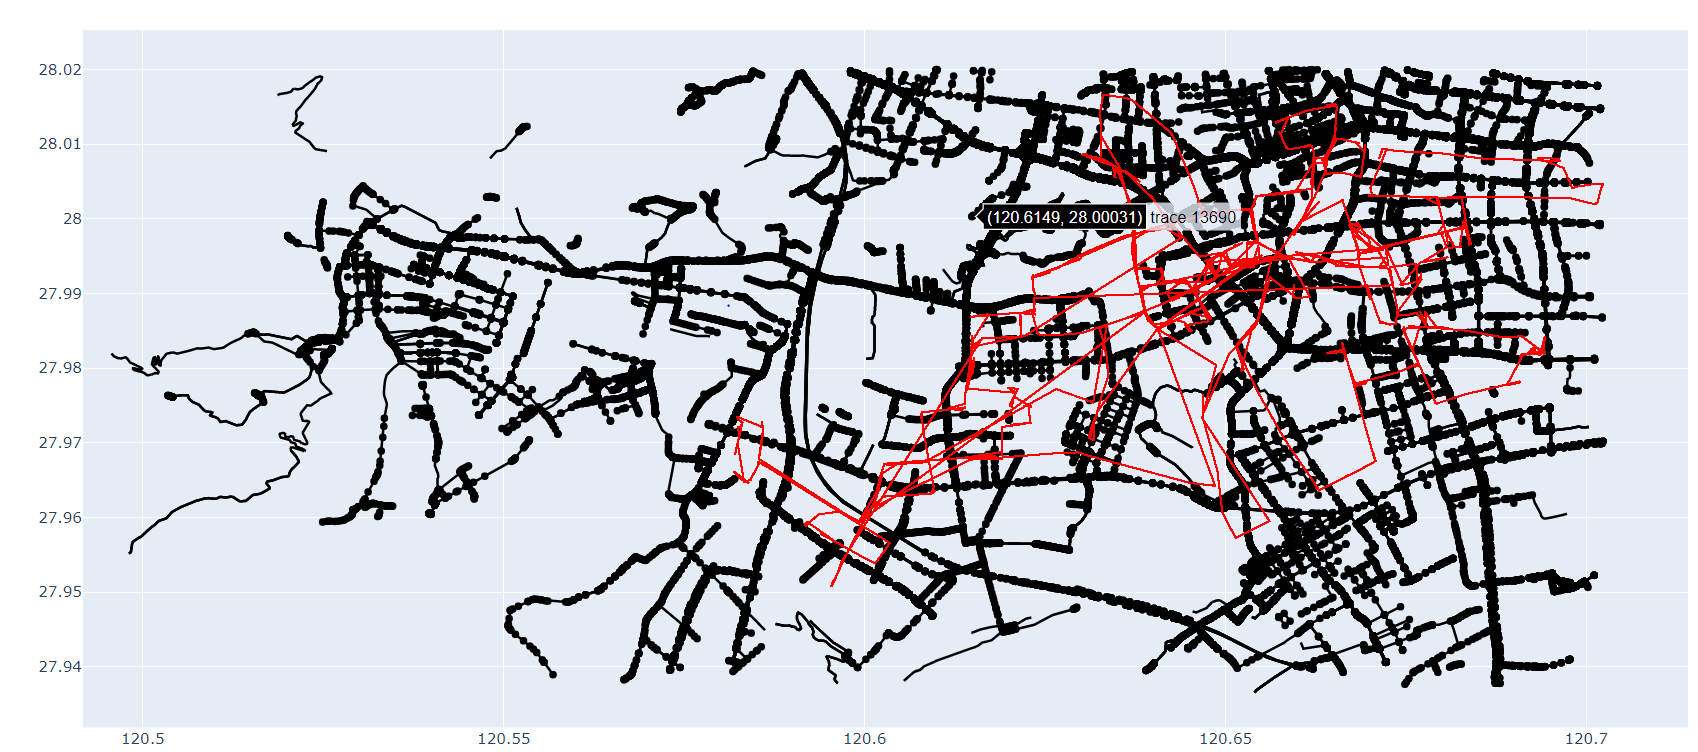

之后的工作证明GPS信息没有很多的偏移，偏移来自与坐标系的不同，高德采取的坐标系与出租车GPS位置的坐标系不同，可以通过坐标系转换修正